# Building a model from scratch

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

2025-01-22 17:38:39.646336: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-22 17:38:39.664222: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737567519.683975     186 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737567519.690095     186 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-22 17:38:39.710432: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Loading image metadata

In [2]:
def get_image_meta(data_path):
    """Retrieve basic metadata (file_path, category)"""
    
    file_meta = []

    for name in os.listdir(data_path): 
        filepath = os.path.join(data_path, name)

        if '.DS_Store' in filepath:
            continue

        for image_file_name in os.listdir(filepath): 
            image_filepath = os.path.join(filepath, image_file_name)

            attrs = {
                'category': name,
                'file_path': image_filepath,
            }
            file_meta.append(attrs)

    return file_meta 

In [4]:
data_file_path = "../data/clean_fer_2013/"

In [5]:
train_data_folder = data_file_path + "train/"

meta_train = get_image_meta(train_data_folder)

df_meta_train = pd.DataFrame(meta_train)
df_meta_train.head()

,category,file_path
0,sad,../data/clean_fer_2013/train/sad/Training_8912...
1,sad,../data/clean_fer_2013/train/sad/Training_7374...
2,sad,../data/clean_fer_2013/train/sad/Training_9509...
3,sad,../data/clean_fer_2013/train/sad/Training_7259...
4,sad,../data/clean_fer_2013/train/sad/Training_3215...


In [6]:
val_data_folder = data_file_path + "validation/"

meta_val = get_image_meta(val_data_folder)

df_meta_val = pd.DataFrame(meta_val)
df_meta_val.head()

,category,file_path
0,sad,../data/clean_fer_2013/validation/sad/PublicTe...
1,sad,../data/clean_fer_2013/validation/sad/PublicTe...
2,sad,../data/clean_fer_2013/validation/sad/PublicTe...
3,sad,../data/clean_fer_2013/validation/sad/PublicTe...
4,sad,../data/clean_fer_2013/validation/sad/PublicTe...


## Base Scratch Model Configuration

Our input shape is `(48,48,1)` to reflect the dimensions (48,48) and channel (grayscale) of our image data.

**Convolutional Layers: Feature Extraction**

Our base model has 3 convolutional layers which perform feature extraction. The number of filters increases with the number of layers with the idea that initial layers will detect low level features and deeper layers can work on extracting more complexity. I have used `padding='same'` to ensure the output size is the same as the input size and we do not ignore edge pixels. The algorithm will go over the images in 1 pixel steps with a 3 x 3 kernel.

**Dense Layers**

In the dense layers, we combine features to perform the image classification. I start with a couple of layers here.

**Optimizer**

We will use the Adam Optimizer with the default learning rate.

**Loss function**

Since we are performing multiclass classification, we will use categorical cross-entropy loss.

**Evaluation**

At the end of each epoch of training, we will use the validation data to evaluate how well the model is performing. Accuracy here compares the predicted probability of a class with the true label (if the predicted label has probability greater than 0.5 and matches the true label then it is considered accurate).

In [26]:
input_shape = (48,48,1)
num_categories = 7 # we have 7 emotions

base_model = tf.keras.Sequential([
    keras.layers.InputLayer(shape=input_shape),

    # First Convolutional Layer (32 filters)
    keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Layer (64 filters)
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
     keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional Layer (128 filters)
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
     keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),

    # Final output layer
    keras.layers.Dense(num_categories, activation='softmax') 
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)

loss = keras.losses.CategoricalCrossentropy(from_logits=False)

base_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

base_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 691,335 (2.64 MB)

 Trainable params: 691,335 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

## Preparing the datasets for training

I need a `label_encoder` to one-hot-encode the categories (which are currently in string format).

I have also added a `preprocess_input` function. At the moment this normalizes the image (converting all pixels into a [0,1] range) but it can be expanded in the future to perform additional steps e.g. to resize images and convert images to grayscale.

I shuffle the dataset to prevent any kind of order bias.

I use `prefetch` to improve performance: it will start preparing the next batch of data while the model is training the current batch.

We start with a batch_size of 32 to balance memory consumption (not too much data is loaded into memory) and speed (might take longer than a larger batch size but hopefully not too bad).

In [27]:
def preprocess_input(image_path):
    """Preprocess Input"""
    try:
        image_file = tf.io.read_file(image_path)
    except:
        print(f"Issue loading {image_file}")
        return None

    image = tf.image.decode_jpeg(image_file, channels=1)
    image = tf.image.resize(image, (48, 48))
        
    image = image / 255.0 
    return image

def create_label_encoder(categories):
    """Create a mapping from category names to integer indices and perform one hot encoding"""
    return tf.keras.layers.StringLookup(vocabulary=categories, 
                                                output_mode='one_hot', 
                                                num_oov_indices=0)

def create_dataset(image_paths, labels, label_encoder, batch_size=32):
    """Load the dataset from file paths, apply preprocessing and group into batches"""
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_input(x), tf.squeeze(label_encoder(y))))
    dataset = dataset.batch(batch_size)
    dataset = dataset.shuffle(buffer_size=1000)  # Shuffle the dataset
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)  # Prefetch for better performance
    return dataset

In [28]:
train_labels = df_meta_train["category"].values
train_image_paths = df_meta_train["file_path"].values

val_labels = df_meta_val["category"].values
val_image_paths = df_meta_val["file_path"].values

categories = list(df_meta_train["category"].unique())
label_encoder = create_label_encoder(categories)

train_dataset = create_dataset(train_image_paths, train_labels, label_encoder, batch_size=32)
val_dataset = create_dataset(val_image_paths, val_labels, label_encoder, batch_size=32)

In [ ]:
expected_num_iterations_per_epoch = len(train_dataset)
length_training_data = len(train_dataset) * 32
length_validation_data = len(val_dataset) * 32

expected_num_iterations_per_epoch, length_training_data, length_validation_data

## Training the scratch model

I train the initial base model across 30 epochs to get a sense of its general performance. The default learning rate seems quite low so I wanted to train for more than the standard 10 epochs.

In [31]:
history = base_model.fit(
    train_dataset,          
    epochs=30,           
    validation_data=val_dataset  
)

Epoch 1/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.2525 - loss: 1.8344 - val_accuracy: 0.2432 - val_loss: 1.8222
Epoch 2/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2291 - loss: 1.8204 - val_accuracy: 0.2277 - val_loss: 1.8486
Epoch 3/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2527 - loss: 1.8032 - val_accuracy: 0.2516 - val_loss: 1.8064
Epoch 4/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2731 - loss: 1.8065 - val_accuracy: 0.1872 - val_loss: 1.8615
Epoch 5/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2669 - loss: 1.8139 - val_accuracy: 0.2516 - val_loss: 1.7969
Epoch 6/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2533 - loss: 1.7722 - val_accuracy: 0.2895 - val_loss: 1.7403
Epoch 7/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2737 - loss: 1.7372 - val_accuracy: 0.3292 - val_loss: 1.6611
Epoch 8/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3255 - loss: 1.6580 - val_accuracy: 0

**Evaluation**

Looking at these first results, you can see that the accuracy on the validation set doesn't get much better than 50%. 

You can also see that the validation loss starts to increase after around 18 epochs, which can be an indication of overfitting.

50% is not a great accuracy score and training for longer with the current model doesn't seem to help. Before we start tweaking our current model, it would be interesting to see if a pretrained model will give us better performance. 

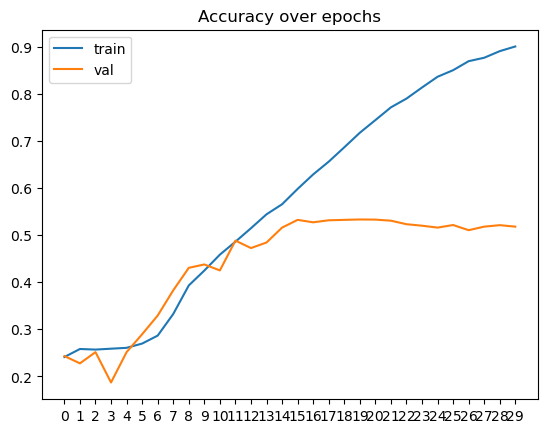

In [35]:
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.xticks(np.arange(30))
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

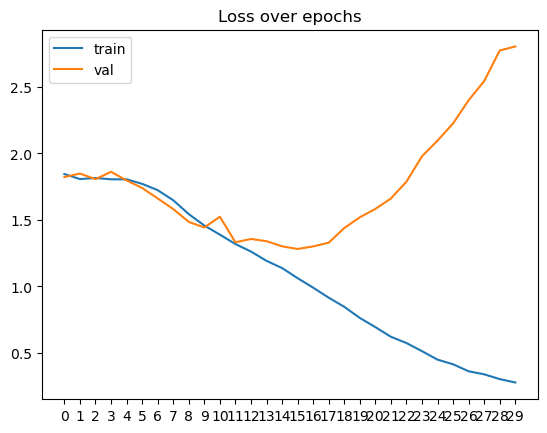

In [36]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.xticks(np.arange(30))
plt.legend()
plt.title("Loss over epochs")
plt.show()